In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import plotly.express as px

import statsmodels.api as sm

from IPython.display import display

## Limpeza dos dados

In [3]:
df0 = pd.read_csv('sao-paulo-properties-april-2019.csv')
display(df0.head(3))
display(df0.shape)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665


(13640, 16)

`conferimos se há valor nulo (nan) no dataframe`

In [4]:
display(df0.isnull().sum())

Price               0
Condo               0
Size                0
Rooms               0
Toilets             0
Suites              0
Parking             0
Elevator            0
Furnished           0
Swimming Pool       0
New                 0
District            0
Negotiation Type    0
Property Type       0
Latitude            0
Longitude           0
dtype: int64

In [5]:
display(df0.dtypes)

Price                 int64
Condo                 int64
Size                  int64
Rooms                 int64
Toilets               int64
Suites                int64
Parking               int64
Elevator              int64
Furnished             int64
Swimming Pool         int64
New                   int64
District             object
Negotiation Type     object
Property Type        object
Latitude            float64
Longitude           float64
dtype: object

`Analisamos quias series tinham valores binários que deveriamos substituir por 'sim' ou 'não', ou valores irrelevantes para a análise por terem valor constante. Assim por uma questão de visivelmente não ser o caso das series ['Price', 'Condo', 'Size', 'District', 'Latitude','Longitude'] já as excluímos dessa análise`

In [6]:
display(df0['Rooms'].unique())
display(df0['Toilets'].unique())
display(df0['Suites'].unique())
display(df0['Parking'].unique())
display(df0['Elevator'].unique())
display(df0['Furnished'].unique())
display(df0['Swimming Pool'].unique())
display(df0['New'].unique())
display(df0['Negotiation Type'].unique())
display(df0['Property Type'].unique())


array([ 2,  1,  3,  4,  5, 10,  6,  7], dtype=int64)

array([2, 3, 4, 1, 5, 6, 7, 8], dtype=int64)

array([1, 3, 2, 4, 0, 5, 6], dtype=int64)

array([1, 2, 3, 4, 5, 6, 8, 9, 0, 7], dtype=int64)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array(['rent', 'sale'], dtype=object)

array(['apartment'], dtype=object)

`Concluímos que as séries ['Elevator, Furnished, Swimming Pool, New'] podem ser transformadas
em categorias. Além disso, consideramos que as séries ['Latitude, Longitude'] podem ser desconsideradas na análise de preços pois a série ['District'] já permite analisar a interferência da região no preço. Ademais, a série ['Property Type'] tem todos os valores iguais e por isso pode ser descartado.`

`Verificamos que 52,99 % dos nossos dados eram sobre apartamentos sendo alugados, 47,01 % sobre apartamentos sendo vendidos. Por isso decidimos trabalhar na previsão dos preços de alugueis.`

rent: 52.99 %
sale: 47.01 %


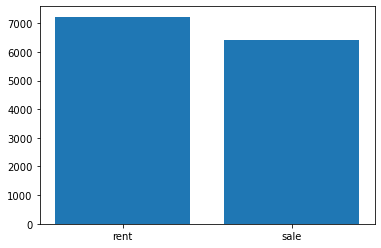

In [7]:
l_values = df0['Negotiation Type'].value_counts()

print(f'rent: {l_values[0]/df0.shape[0]*100:.2f} %')
print(f'sale: {l_values[1]/df0.shape[0]*100:.2f} %')
plt.bar(df0['Negotiation Type'].unique(), l_values)
plt.show()

# optamos por analizar somente os preços dos aps. alugados pois avisa uma base de dados
# um pouco maior

`Retiramos as séries consideradas descartáveis e filtramos apenas as linhas selencionando apenas as que tinham apartamentos sendo alugados.`

In [8]:
rent = df0['Negotiation Type'] == 'rent'
df = df0.loc[rent,['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District']]

# df para regressão linear
df_rl = df.drop(columns='District', axis=1)

`Transformamos as séries binárias e a séries não numéricas em categorias e substituímos os valores 0 e 1 por não e sim respectivamente.`

In [34]:
df['District'] = df['District'].astype('category')

df['Swimming Pool'] = df['Swimming Pool'].astype('category')
df['New'] = df['New'].astype('category')
df['Furnished'] = df['Furnished'].astype('category')
df['Elevator'] = df['Elevator'].astype('category')

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim
...,...,...,...,...,...,...,...,...,...,...,...,...
11205,3700,595,73,1,2,1,1,0,0,1,0,Brooklin
11206,21000,3000,208,4,4,3,3,1,1,1,0,Brooklin
11207,3800,710,55,1,1,0,1,0,1,1,0,Brooklin
11208,5000,2354,205,3,2,1,2,1,0,0,0,Brooklin


In [36]:
df['Swimming Pool'].cat.categories = ['No', 'Yes']
df['Furnished'].cat.categories = ['No', 'Yes']
df['Elevator'].cat.categories = ['No', 'Yes']
df['New'].cat.categories = ['No', 'Yes']
df['Swimming Pool'].cat.categories = ['No', 'Yes']

df

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
0,930,220,47,2,2,1,1,No,No,0,No,Artur Alvim
1,1000,148,45,2,2,1,1,No,No,0,No,Artur Alvim
2,1000,100,48,2,2,1,1,No,No,0,No,Artur Alvim
3,1000,200,48,2,2,1,1,No,No,0,No,Artur Alvim
4,1300,410,55,2,2,1,1,Yes,No,0,No,Artur Alvim
...,...,...,...,...,...,...,...,...,...,...,...,...
11205,3700,595,73,1,2,1,1,No,No,1,No,Brooklin
11206,21000,3000,208,4,4,3,3,Yes,Yes,1,No,Brooklin
11207,3800,710,55,1,1,0,1,No,Yes,1,No,Brooklin
11208,5000,2354,205,3,2,1,2,Yes,No,0,No,Brooklin


`confirmamos que todos os dados são da cidade de São Paulo`

In [11]:
df[['District','City']] = df['District'].str.split('/', expand = True)
display(df.City.unique())

array(['São Paulo'], dtype=object)

`Limpamos a série ['District'], retirando a informação de que os bairros são da cidade de São Paulo.`

In [12]:
df = df.drop(columns='City', axis=1)
df['District'] = df['District'].astype('category')

In [13]:
display(df.sort_values(by='Price').head())
display(df.shape)
display(df.dtypes)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
508,480,295,48,2,2,1,1,No,No,No,No,São Rafael
4486,500,380,66,2,1,0,1,No,No,No,No,Jaraguá
2878,500,36,45,1,2,1,0,No,No,Yes,No,Vila Maria
288,500,0,40,1,2,1,1,No,No,No,No,Jardim Helena
122,500,0,50,1,2,1,1,No,No,No,No,Cidade Líder


(7228, 12)

Price               int64
Condo               int64
Size                int64
Rooms               int64
Toilets             int64
Suites              int64
Parking             int64
Elevator         category
Furnished        category
Swimming Pool    category
New              category
District         category
dtype: object

## Análize dos dados

In [18]:
# df2 = df.loc[:, ['Price', 'New']]

# px.histogram(df2, x='Price', color='New') # opacity=0.5,

In [19]:
# df2 = df.loc[:, ['Price', 'Swimming Pool']]

# px.histogram(df2, x='Price', color='Swimming Pool') # opacity=0.5,

In [20]:
# df2 = df.loc[:, ['Price', 'Furnished']]

# px.histogram(df2, x='Price', color='Furnished') # opacity=0.5,

In [21]:
# df2 = df.loc[:, ['Price', 'Elevator']]

# px.histogram(df2, x='Price', color='Elevator') # opacity=0.5,

<Figure size 720x5040 with 0 Axes>

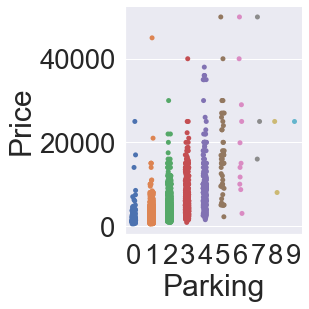

In [22]:
plt.figure(figsize=(10, 70))
ax = sns.catplot(x='Parking', y = 'Price', data=df)
plt.show()

In [23]:
# # ['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator', 'Furnished', 'Swimming Pool', 'District', 'Property Type']
# print(f'Correlação Price/Condo: {df.Price.corr(df.Condo)*100:.3f} %')
# print(f'Correlação Price/Size: {df.Price.corr(df.Size)*100:.3f} %')
# print(f'Correlação Price/Rooms: {df.Price.corr(df.Rooms)*100:.3f} %')
# print(f'Correlação Price/Toilets: {df.Price.corr(df.Toilets)*100:.3f} %')
# print(f'Correlação Price/Suites: {df.Price.corr(df.Suites)*100:.3f} %')
# print(f'Correlação Price/Parking: {df.Price.corr(df.Parking)*100:.3f} %')
# # print(f'Correlação Price\Elevator: {df.Price.corr(df.Elevator)*100:.3f} %')
# # print(f'Correlação Price\Furnished: {df.Price.corr(df.Furnished)*100:.3f} %')
# # # print(f'Correlação Price/Swimming Pool: {df['Price'].corr(df['Swimming Pool'])*100:.3f} %')
# # print(f'Correlação Price\District: {df.Price.corr(df.District)*100:.3f} %')
# # # print(f'Correlação Price/Property Type: {df.Price.corr(df.Property Type)*100:.3f} %')

In [24]:
# Price	Condo	Size	Rooms	Toilets	Suites

## test train

In [66]:
X_test = pd.read_csv('X_test.csv')
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

## Regressão Linear

In [67]:
def regress(Y, X):

    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    r = model.fit()
    
    return r

In [68]:
X_train['Swimming Pool'] = X_train['Swimming Pool'].astype('category')
X_train['New'] = X_train['New'].astype('category')
X_train['Furnished'] = X_train['Furnished'].astype('category')
X_train['Elevator'] = X_train['Elevator'].astype('category')

X_train['Swimming Pool'].cat.categories = ['0', '1']
X_train['Furnished'].cat.categories = ['0', '1']
X_train['Elevator'].cat.categories = ['0', '1']
X_train['New'].cat.categories = ['0', '1']

X_train['Swimming Pool'] = X_train['Swimming Pool'].astype('int64')
X_train['New'] = X_train['New'].astype('int64')
X_train['Furnished'] = X_train['Furnished'].astype('int64')
X_train['Elevator'] = X_train['Elevator'].astype('int64')

In [70]:
Y = y_train['Price']
X = X_train[['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator', 'Furnished', 'Swimming Pool', 'New']]
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     898.8
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        20:50:27   Log-Likelihood:                -52677.
No. Observations:                5782   AIC:                         1.054e+05
Df Residuals:                    5771   BIC:                         1.054e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -15.7238    114.334     -0.138      0.891    -239.861     208.413
Condo             0.9004      0.065     13.926      0.000       0.774       1.027
Size             27.6610      1.009     27.427      0.000      25.684      29.638
Rooms          -746.7056     49.616    -15.050      0.000    -843.972    -649.439
Toilets         210.0955     78.942      2.661      0.008      55.340     364.851
Suites          169.4692     89.518      1.893      0.058      -6.020     344.958
Parking         486.9709     57.660      8.446      0.000     373.936     600.006
Elevator        -93.3106     65.273     -1.430      0.153    -221.270      34.649
Furnished      1095.7383     78.900     13.888      0.000     941.065    1250.411
Swimming Pool   223.3972     62.956      3.548      0.000      99.980     346.814
New            -257.3482    897.166     -0.287      0.774   -2016.131    1501.434
==============================================================================
Omnibus:                     5115.530   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           566733.591
Skew:                           3.743   Prob(JB):                         0.00
Kurtosis:                      50.920   Cond. No.                     3.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
X = X.drop(columns='New', axis=1)
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     998.9
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        20:50:33   Log-Likelihood:                -52677.
No. Observations:                5782   AIC:                         1.054e+05
Df Residuals:                    5772   BIC:                         1.054e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -16.2623    114.309     -0.142      0.887    -240.351     207.827
Condo             0.9005      0.065     13.930      0.000       0.774       1.027
Size             27.6627      1.008     27.431      0.000      25.686      29.640
Rooms          -746.4401     49.604    -15.048      0.000    -843.682    -649.198
Toilets         210.3145     78.932      2.665      0.008      55.579     365.050
Suites          169.3818     89.511      1.892      0.058      -6.092     344.856
Parking         486.5639     57.638      8.442      0.000     373.572     599.555
Elevator        -94.1991     65.194     -1.445      0.149    -222.004      33.606
Furnished      1095.6834     78.893     13.888      0.000     941.023    1250.344
Swimming Pool   223.1581     62.945      3.545      0.000      99.762     346.554
==============================================================================
Omnibus:                     5115.347   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           566647.674
Skew:                           3.743   Prob(JB):                         0.00
Kurtosis:                      50.917   Cond. No.                     5.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
X = X.drop(columns='Elevator', axis=1)
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1123.
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        20:51:08   Log-Likelihood:                -52678.
No. Observations:                5782   AIC:                         1.054e+05
Df Residuals:                    5773   BIC:                         1.054e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -27.1481    114.071     -0.238      0.812    -250.771     196.475
Condo             0.9006      0.065     13.929      0.000       0.774       1.027
Size             27.7237      1.008     27.513      0.000      25.748      29.699
Rooms          -744.0567     49.581    -15.007      0.000    -841.254    -646.860
Toilets         193.8506     78.112      2.482      0.013      40.721     346.980
Suites          175.5033     89.419      1.963      0.050       0.209     350.797
Parking         491.2324     57.553      8.535      0.000     378.408     604.057
Furnished      1088.2801     78.734     13.822      0.000     933.932    1242.628
Swimming Pool   212.8549     62.546      3.403      0.001      90.241     335.468
==============================================================================
Omnibus:                     5114.143   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           567851.522
Skew:                           3.741   Prob(JB):                         0.00
Kurtosis:                      50.969   Cond. No.                     5.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
X = X.drop(columns='Suites', axis=1)
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1283.
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        20:51:50   Log-Likelihood:                -52680.
No. Observations:                5782   AIC:                         1.054e+05
Df Residuals:                    5774   BIC:                         1.054e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -148.9445     95.739     -1.556      0.120    -336.629      38.740
Condo             0.8930      0.065     13.833      0.000       0.766       1.020
Size             27.9410      1.002     27.891      0.000      25.977      29.905
Rooms          -747.4721     49.563    -15.081      0.000    -844.633    -650.311
Toilets         320.1626     44.281      7.230      0.000     233.355     406.970
Parking         509.8007     56.784      8.978      0.000     398.483     621.118
Furnished      1090.9267     78.742     13.854      0.000     936.563    1245.290
Swimming Pool   217.6939     62.513      3.482      0.001      95.145     340.242
==============================================================================
Omnibus:                     5111.132   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           565214.658
Skew:                           3.739   Prob(JB):                         0.00
Kurtosis:                      50.856   Cond. No.                     4.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
X = X.drop(columns='Swimming Pool', axis=1)
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1491.
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        20:52:10   Log-Likelihood:                -52686.
No. Observations:                5782   AIC:                         1.054e+05
Df Residuals:                    5775   BIC:                         1.054e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -120.6039     95.484     -1.263      0.207    -307.789      66.581
Condo          0.9076      0.064     14.076      0.000       0.781       1.034
Size          27.3724      0.989     27.667      0.000      25.433      29.312
Rooms       -740.3544     49.568    -14.936      0.000    -837.526    -643.182
Toilets      337.3634     44.047      7.659      0.000     251.014     423.712
Parking      548.5833     55.734      9.843      0.000     439.323     657.844
Furnished   1135.4266     77.773     14.599      0.000     982.963    1287.891
==============================================================================
Omnibus:                     5098.181   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           558957.945
Skew:                           3.725   Prob(JB):                         0.00
Kurtosis:                      50.588   Cond. No.                     4.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Referêcias

- Análise de dados e previsão de preços: https://www.kaggle.com/code/juxwzera/predictions-for-price